In [1]:
import matplotlib.pyplot as plt

from casadi import *

In [2]:
N = 100

opti = Opti()  # optimization problem

In [3]:
X = opti.variable(2,N+1)  # state variables for all k

p = X[0,:]  # position
v = X[1,:]  # speed

v_lim = lambda pos: 1 - sin(2 * pi * pos) / 2
opti.subject_to(v <= v_lim(p))

U = opti.variable(1,N)  # control trajectory
opti.subject_to(0 <= U)
opti.subject_to(U <= 1)

T = opti.variable()  # final time
opti.subject_to(T >= 0)

# boundary
opti.subject_to(p[0] == 0)
opti.subject_to(v[0] == 0)
opti.subject_to(p[N] == 1)

In [4]:
opti.minimize(T)

In [5]:
opti

Opti(Opti {
  instance #0
  #variables: 3 (nx = 303)
  #parameters: 0 (np = 0)
  #constraints: 7 (ng = 305)
  CasADi solver needs updating.
})

In [6]:
f = lambda x, u: vertcat(x[1], u - x[1])

dt = T/N
for k in range(N):
    k1 = f(X[:,k],U[:,k])
    k2 = f(X[:,k] + (dt / 2) * k1, U[:,k])
    k3 = f(X[:,k] + (dt / 2) * k1, U[:,k])
    k4 = f(X[:,k] + dt * k3, U[:,k])

    x_next = X[:,k] + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

    opti.subject_to(X[:,k+1] == x_next)

In [7]:
# initial guess
opti.set_initial(v, 1)
opti.set_initial(T, 1)

opti.solver('ipopt')  # set numerical backend
sol = opti.solve()  # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      403
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality co

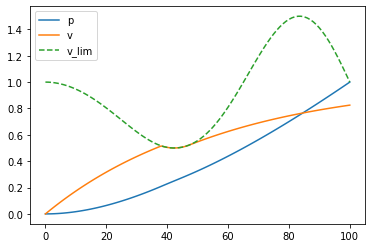

In [8]:
plt.plot(sol.value(p), label='p')
plt.plot(sol.value(v), label='v')
plt.plot(v_lim(sol.value(p)), '--', label='v_lim')

plt.legend()
plt.show()